In [1]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
import jax # type: ignore
from jax import numpy as jnp # type: ignore
from jax import random as jr # type: ignore
from jax import vmap # type: ignore
import blackjax # type: ignore
import jax.scipy.stats as jss # type: ignore
from jax.scipy.special import logsumexp as lse # type: ignore
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore
import numpy as onp # type: ignore

from utils import reshape_emissions
from density_models import MAF
from flax import nnx # type: ignore
from matplotlib import pyplot as plt # type: ignore
from parameters import params_from_tree, sample_ssm_params, initialize, to_train_array, log_prior, get_unravel_fn, join_trees, tree_from_params
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
import tensorflow_probability.substrates.jax.bijectors as tfb # type: ignore
from simulation_inference import sample_and_train
from ssm import LGSSM
from filters import bpf

from datetime import date
import csv
import time

import scienceplots # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib_inline # type: ignore
plt.style.use(['science', 'ieee'])
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# Define inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

## Initialize model and simulate dataset

In [3]:
num_timesteps = 100 # Number of emissions timesteps
num_mcmc_steps = 1000 # Number of MCMC steps

state_dim = 4
emission_dim = 2
input_dim = 0

initial_mean = jnp.zeros(state_dim)
initial_covariance = jnp.eye(state_dim) * 0.1

dynamics_weights  = 0.9 * jnp.eye(state_dim)
dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 0.1

emission_weights = jnp.eye(emission_dim, state_dim)
emission_bias = jnp.zeros(emission_dim)
emission_input_weights = jnp.zeros((emission_dim, input_dim))
emission_covariance = jnp.eye(emission_dim) * 0.1

# Initialize params and props
m = state_dim * (state_dim + 1) // 2
dynamics_covariance_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag=0.1*jnp.ones(m))

param_names = [['mean', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov']]

prior_fields = [[initial_mean, initial_covariance],
                [dynamics_weights, dynamics_bias, dynamics_input_weights, dynamics_covariance_dist],
                [emission_weights, emission_bias, emission_input_weights, emission_covariance]]

is_constrained_tree = [[True, True], # The tree state at initialization
                       [True, True, True, False], 
                       [True, True, True, True]]

constrainers  = [[None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector]]

props, prior = initialize(prior_fields, param_names, constrainers)

### Sample ***true*** params and emissions

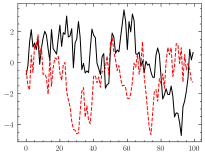

In [4]:
seed = int(time.time() * 1000)  # Milliseconds for more granularity
key = jax.random.PRNGKey(seed)
key, subkey = jr.split(key)
true_lgssm = LGSSM(state_dim, emission_dim)
[true_params, example_params] = sample_ssm_params(key, prior, 2)
true_params.from_unconstrained(props)
states, emissions = true_lgssm.simulate(subkey, true_params, num_timesteps)

plt.plot(emissions)
plt.show()

In [5]:
print(1, 'as initialized', example_params)
example_params.from_unconstrained(props)
print(2, 'constrained', example_params)
example_params.to_unconstrained(props)
print(3, 'unconstrained', example_params)

1 as initialized ParamSSM(initial=ParamField(mean=ParamNode(value=[0. 0. 0. 0.], is_constrained=True), cov=ParamNode(value=[[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]], is_constrained=True)), dynamics=ParamField(weights=ParamNode(value=[[0.9 0.  0.  0. ]
 [0.  0.9 0.  0. ]
 [0.  0.  0.9 0. ]
 [0.  0.  0.  0.9]], is_constrained=True), bias=ParamNode(value=[0. 0. 0. 0.], is_constrained=True), input_weights=ParamNode(value=[], is_constrained=True), cov=ParamNode(value=[-0.11023337 -0.00181604  0.00497697  0.01132857 -0.06407844 -0.10427525
 -0.11932573 -0.14418052 -0.15400308 -0.03191895], is_constrained=False)), emissions=ParamField(weights=ParamNode(value=[[1. 0. 0. 0.]
 [0. 1. 0. 0.]], is_constrained=True), bias=ParamNode(value=[0. 0.], is_constrained=True), input_weights=ParamNode(value=[], is_constrained=True), cov=ParamNode(value=[[0.1 0. ]
 [0.  0.1]], is_constrained=True))
2 constrained ParamSSM(initial=ParamField(mean=ParamNode(value=[0. 0. 0. 0.],

## Train TAF model

In [6]:
lag = 10
din = emission_dim
n_params = to_train_array(example_params, props).shape[0]
dcond = lag * emission_dim + n_params
reverse = True
random_order = False
batch_norm = False
dropout = False
nmades = 5
dhidden = 32
nhidden = 5

# Initialize models
model = MAF(din, nmades, dhidden, nhidden, dcond, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)
test_lgssm = LGSSM(state_dim, emission_dim)

# Sample parameters for first round
num_samples = 10
key, subkey = jr.split(key)
params_sample = sample_ssm_params(subkey, prior, num_samples) # Here, output params are in mixed constrained/unconstrained form
                                                              # The trainable params (given in prior by dist) are unconstrained
                                                              # whereas the not-trainable params (given in prior by arrays) are constrained
                                                              # In the trainer, the cond_params are appended to the dataset and then the params are converted
                                                              # to constrained form before being passed to the model for simulation. 
dataset = jnp.array([])
num_rounds = 2
params_samples_allrounds = []
for r in range(num_rounds):
    print(f"-Round {r}")

    # Add previous samples to samples
    params_samples_allrounds.append(params_sample)    

    # Sample SSM emissions and train TAF
    key, subkey1, subkey2 = jr.split(key, 3)
    model, dataset = sample_and_train(
        key = subkey1,
        model = model,
        ssmodel = test_lgssm,
        params_sample = params_sample,
        example_params = example_params, 
        prev_dataset = dataset, 
        lag = lag,
        num_timesteps = num_timesteps, 
        props = props,
        num_epochs = 20,
        learning_rate = 1 * 1e-4,
        verbose=True
    )

    # Sample new parameters using TAF likelihood and MCMC
    print("-Sampling new parameters")

    ## Define TAF-based logdensity function
    def taf_logdensity_fn(cond_params):
        lagged_emissions = reshape_emissions(emissions, lag)
        tile_cond_params = jnp.tile(cond_params, (lagged_emissions.shape[0], 1))
        lp = -model.loss_fn(jnp.concatenate([tile_cond_params, lagged_emissions], axis=1))
        lp += log_prior(cond_params, prior)
        return lp

    ## Initialize MCMC chain and kernel
    rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
    initial_cond_params = to_train_array(sample_ssm_params(rng_key, prior, 1)[0], props)
    taf_random_walk = blackjax.additive_step_random_walk(taf_logdensity_fn, blackjax.mcmc.random_walk.normal(0.1))
    taf_initial_state = taf_random_walk.init(initial_cond_params)
    taf_kernel = jax.jit(taf_random_walk.step)

    ## Run inference loop
    rng_key, sample_key1, sample_key2 = jax.random.split(rng_key, 3)
    taf_mcmc_states = inference_loop(sample_key1, taf_kernel, taf_initial_state, num_mcmc_steps)
    positions = taf_mcmc_states.position[-num_samples:]
    params_sample = []
    print("-Adding new params")
    for cond_param in positions:
        unravel_fn = get_unravel_fn(example_params, props)
        unravel = unravel_fn(cond_param)
        tree = tree_from_params(example_params)
        new_tree = join_trees(unravel, tree, props)
        param = params_from_tree(new_tree, param_names, is_constrained_tree)
        params_sample.append(param)

# Add samples from final round
params_samples_allrounds.append(params_sample)

-Round 0


TypeError: sample_and_train() got an unexpected keyword argument 'example_params'

### Log-likelihood plots (for MAF)

In [13]:
# covs = []
# for param in params_samples_allrounds[0]:
#     param.to_unconstrained(props)
#     covs.append(param.dynamics.cov.value)
# thetas = jnp.array(covs).flatten()
# thetas = jnp.sort(thetas)

# log_density_values = vmap(lambda param: logdensity_fn(model, prior, param, emissions, lag))(thetas[:, None])
# log_likelihood_values = vmap(lambda param: loglik(model, param, emissions, lag))(thetas[:, None])
# true_log_likelihood_values = vmap(lambda theta: true_loglik(theta, emissions, state_dim, emission_dim, props, example_params, param_names, is_constrained_tree))(thetas[:, None])

# true_log_likelihood_values = true_log_likelihood_values - jnp.min(true_log_likelihood_values)
# true_log_likelihood_values = true_log_likelihood_values / jnp.max(true_log_likelihood_values)
# log_density_values = log_density_values - jnp.min(log_density_values)
# log_density_values = log_density_values / jnp.max(log_density_values)
# log_likelihood_values = log_likelihood_values - jnp.min(log_likelihood_values)
# log_likelihood_values = log_likelihood_values / jnp.max(log_likelihood_values)

# plt.plot(thetas, log_density_values, label='log density')
# plt.plot(thetas, log_likelihood_values, label='loglik')
# plt.plot(thetas, true_log_likelihood_values, label='True loglik')
# plt.vlines(thetas, 0, 1, color='blue', alpha=0.02)
# plt.vlines(RealToPSDBijector().inverse(true_params.dynamics.cov.value), 0, 1, color='red', label='True cov', linestyle='--', alpha=0.2)
# plt.legend()
# plt.show()

# print('true loglik argmax', thetas[jnp.argmax(true_log_likelihood_values)])
# print('est loglik argmax', thetas[jnp.argmax(log_likelihood_values)])
# print('est log density argmax', thetas[jnp.argmax(log_density_values)])
# print('true param value', RealToPSDBijector().inverse(true_params.dynamics.cov.value))

## Posterior inference

In [14]:
num_particles = 1000 # Number of particles for BPF
num_iters = 5 # Number of iterations for BPF likelihood estimator

# Define the log-density function
def bpf_logdensity_fn(cond_params):
    unravel_fn = get_unravel_fn(example_params, props)
    unravel = unravel_fn(cond_params)
    tree = tree_from_params(example_params)
    new_tree = join_trees(unravel, tree, props)
    params = params_from_tree(new_tree, param_names, is_constrained_tree)
    params.from_unconstrained(props)
    lps = []
    for _ in range(num_iters):
        _, lp = bpf(params, test_lgssm, emissions, num_particles, key)
        lp += log_prior(cond_params, prior)
        lps.append(lp)
    return jnp.mean(jnp.array(lps))

def taf_logdensity_fn(cond_params):
    lagged_emissions = reshape_emissions(emissions, lag)
    tile_cond_params = jnp.tile(cond_params, (lagged_emissions.shape[0], 1))
    lp = -model.loss_fn(jnp.concatenate([tile_cond_params, lagged_emissions], axis=1))
    lp += log_prior(cond_params, prior)
    return lp

# Initialize MCMC chain and kernel
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
initial_cond_params = to_train_array(sample_ssm_params(rng_key, prior, 1)[0], props)

rw_sigma = 0.1
taf_random_walk = blackjax.additive_step_random_walk(taf_logdensity_fn, blackjax.mcmc.random_walk.normal(rw_sigma))
bpf_random_walk = blackjax.additive_step_random_walk(bpf_logdensity_fn, blackjax.mcmc.random_walk.normal(rw_sigma))

taf_initial_state = taf_random_walk.init(initial_cond_params)
taf_kernel = jax.jit(taf_random_walk.step)

bpf_initial_state = bpf_random_walk.init(initial_cond_params)
bpf_kernel = jax.jit(bpf_random_walk.step)

# Run inference loop
rng_key, sample_key1, sample_key2 = jax.random.split(rng_key, 3)
taf_mcmc_states = inference_loop(sample_key1, taf_kernel, taf_initial_state, num_mcmc_steps)
bpf_mcmc_states = inference_loop(sample_key2, bpf_kernel, bpf_initial_state, num_mcmc_steps)

### Baseline (MC estimate of posterior normalization)

In [ ]:
from output_utils import true_loglik

# with open('baseline.csv', mode='r') as file:
#     csvFile = csv.reader(file)
#     for line_number, line in enumerate(csvFile):
#         baseline_error = float(line[0])

# if baseline_error == 0.0:
seed = 121241378123 
num_reps = 20
baseline_num_samples = int(1e2)
for i in range(num_reps):
    print(f"------------------ Repetition {i} ------------------")
    key, subkey = jr.split(key)
    true_lgssm = LGSSM(state_dim, emission_dim)
    [true_params, example_params] = sample_ssm_params(key, prior, 2)
    true_params.from_unconstrained(props)
    _, emissions = true_lgssm.simulate(subkey, true_params, num_timesteps)
    covs = []
    key, subkey = jr.split(key)

    prior_samples = sample_ssm_params(subkey, prior, baseline_num_samples)
    for param in prior_samples:
        param.to_unconstrained(props)
        covs.append(param.dynamics.cov.value)
    thetas = jnp.array(covs)
    ctrue_loglik = lambda cond_param: true_loglik(cond_param, emissions, state_dim, emission_dim, props, example_params, param_names, is_constrained_tree)
    true_loglik_vals = vmap(ctrue_loglik)(thetas)
    logZ_hat = lse(true_loglik_vals) - jnp.log(baseline_num_samples)
    baseline_log_posterior = lambda cond_param: ctrue_loglik(cond_param) + log_prior(cond_param, prior) - logZ_hat
    true_params.to_unconstrained(props)
    baseline_error = -baseline_log_posterior(to_train_array(true_params, props))
    true_params.from_unconstrained(props)
    with open("baseline.csv", mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([baseline_error])

------------------ Repetition 0 ------------------
------------------ Repetition 1 ------------------
------------------ Repetition 2 ------------------
------------------ Repetition 3 ------------------
------------------ Repetition 4 ------------------
------------------ Repetition 5 ------------------
------------------ Repetition 6 ------------------
------------------ Repetition 7 ------------------
------------------ Repetition 8 ------------------
------------------ Repetition 9 ------------------
------------------ Repetition 10 ------------------
------------------ Repetition 11 ------------------
------------------ Repetition 12 ------------------
------------------ Repetition 13 ------------------
------------------ Repetition 14 ------------------
------------------ Repetition 15 ------------------
------------------ Repetition 16 ------------------
------------------ Repetition 17 ------------------
------------------ Repetition 18 ------------------
------------------ Rep

## Output

### Kernel density estimation and errors

In [16]:
taf_kernel_points = taf_mcmc_states.position.T
posterior_mean = jnp.mean(taf_kernel_points, axis=1)
taf_kde = jss.gaussian_kde(taf_kernel_points)
taf_num_simulations = num_rounds * num_samples * num_timesteps
taf_error = -jnp.log(taf_kde.evaluate(RealToPSDBijector().inverse(true_params.dynamics.cov.value)))

bpf_kernel_points = bpf_mcmc_states.position.T
bpf_kde = jss.gaussian_kde(bpf_kernel_points)
bpf_num_simulations = num_particles * num_timesteps * num_mcmc_steps * num_iters
bpf_error = -jnp.log(bpf_kde.evaluate(RealToPSDBijector().inverse(true_params.dynamics.cov.value)))

### Print outputs to file

In [17]:
# Define the data to be written
header_row = ["BPF error", "BPF num_sims", "TAF error", "TAF num_sims", "num_timesteps", "num_mcmc_steps", "num_reps", "lag", "num_samples", "num_rounds", "num_particles", "num_iters"]
new_row = [bpf_error[0], jnp.log10(bpf_num_simulations), taf_error[0], jnp.log10(taf_num_simulations)]

# Specify the file name
file_name = "output_lgssm.csv"
# Write the data to the CSV file
with open(file_name, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(new_row)

### Plot from file

In [18]:
import csv
bpf_errors = []
taf_errors = []
bpf_num_sims = []
taf_num_sims = []
file_name = "output_lgssm.csv"
with open(file_name, mode='r') as file:
    csvFile = csv.reader(file)
    for line_number, line in enumerate(csvFile):
        if line_number == 0:
            continue
        else:
            bpf_errors.append(float(line[0]))
            bpf_num_sims.append(float(line[1]))
            taf_errors.append(float(line[2]))
            taf_num_sims.append(float(line[3]))
    bpf_errors = jnp.array(bpf_errors)
    taf_errors = jnp.array(taf_errors)
    bpf_num_sims = jnp.array(bpf_num_sims)
    taf_num_sims = jnp.array(taf_num_sims)

    bpf_errors = bpf_errors[jnp.argsort(bpf_num_sims)]
    bpf_num_sims = bpf_num_sims[jnp.argsort(bpf_num_sims)]
    taf_errors = taf_errors[jnp.argsort(taf_num_sims)]
    taf_num_sims = taf_num_sims[jnp.argsort(taf_num_sims)]

So far I am varying the numbers of simulations by varying:
- `num_samples` and `num_rounds` for TAF
- `num_particles` and `num_iters` for BPF

The reason that BPF has large `num_sims` is that the number of MCMC steps is a factor of the number of simulations. If I take it out something like a per MCMC step count.

I might need to do an averaging of the errors for the TAF model for each experimental setting. This is because I see there is some variability. 

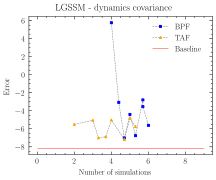

In [19]:
plt.plot(bpf_num_sims-3, bpf_errors, linewidth=0.5, color='gray', markerfacecolor='blue', markeredgecolor='blue', marker='s', markersize=2.0, linestyle='--', label='BPF')
plt.plot(taf_num_sims, taf_errors, linewidth=0.5, color='gray', markerfacecolor='orange', markeredgecolor='orange', marker='^', markersize=2.0, linestyle='--', label='TAF')
plt.hlines(baseline_error, jnp.array([0.0]), jnp.max(jnp.array([bpf_num_sims, taf_num_sims])), color='red', linewidth=0.4, label='Baseline')
plt.xlabel('Number of simulations')
# plt.xticks(jnp.linspace(0, 7, 8), [f'$10^{i}$' for i in range(8)])
plt.ylabel('Error')
plt.title('LGSSM - dynamics covariance')
plt.legend()
plt.show()